In [1]:
import numpy as np

# svd base

In [2]:

results = [0.5928, 0.5366, 0.5561, 0.5447, 0.5091]
mean = np.mean(results)        
std = np.std(results)          

In [3]:
mean

np.float64(0.54786)

In [4]:
std

np.float64(0.02730059340014426)

# svd-large

In [5]:
results = [0.6743,0.6777,0.6766,0.6227,0.6559]
mean = np.mean(results)        
std = np.std(results)       
print(mean)
print(std)

0.66144
0.02093357112391479


# baseline-base

In [8]:
results = [0.5711, 0.5332, 0.547,0.548,0.5091]
mean = np.mean(results)        
std = np.std(results)       
print(mean)
print(std)

0.54168
0.020332968302734376


In [9]:
results = [0.6227,0.6433,0.6834,0.6674,0.6146]
mean = np.mean(results)        
std = np.std(results)       
print(mean)
print(std)

0.64628
0.02604790970500319


/home/xinglixian/miniconda3/envs/semeval26/lib/python3.11/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


A-side: 386238.88, B-side: 340664.75


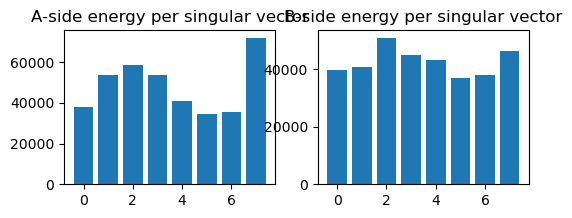

In [ ]:
import torch
import matplotlib.pyplot as plt

d_model, d_head, r = 768, 64, 8
M = torch.randn(d_model, d_head)
U_r = torch.randn(d_model, r)
V_r = torch.randn(d_head, r)

E_A = torch.norm(M @ V_r, p='fro')**2
E_B = torch.norm(U_r.T @ M, p='fro')**2
print(f"A-side: {E_A.item():.2f}, B-side: {E_B.item():.2f}")

e_A_vec = (M @ V_r).pow(2).sum(dim=0).cpu().numpy()
e_B_vec = (U_r.T @ M).pow(2).sum(dim=1).cpu().numpy()

plt.figure(figsize=(6,2))
plt.subplot(1,2,1)
plt.bar(range(r), e_A_vec)
plt.title("A-side energy per singular vector")
plt.subplot(1,2,2)
plt.bar(range(r), e_B_vec)
plt.title("B-side energy per singular vector")
plt.show()


In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt

def load_jsonl(path):
    records = []
    with open(path, "r") as f:
        for line in f:
            records.append(json.loads(line))
    return pd.DataFrame(records)

df_left = load_jsonl("./svd_outputs/left/lora_metrics.jsonl")
df_right = load_jsonl("./svd_outputs/right/lora_metrics.jsonl")
df_leftright = load_jsonl("./svd_outputs/leftright/lora_metrics.jsonl")


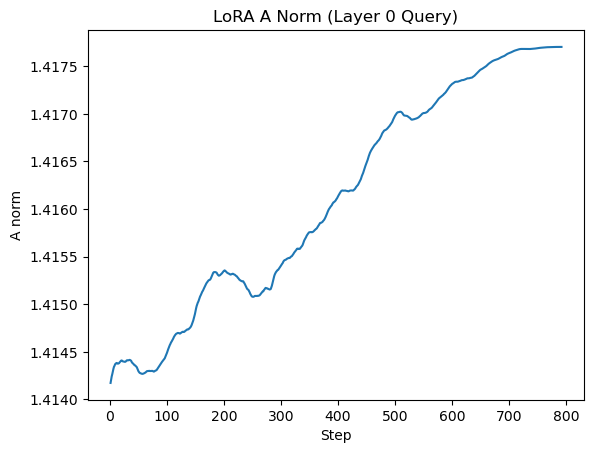

In [2]:
key = "encoder.layer.0.attention.self.query/norm_A"
plt.plot(df["step"], df[key])
plt.xlabel("Step")
plt.ylabel("A norm")
plt.title("LoRA A Norm (Layer 0 Query)")
plt.show()

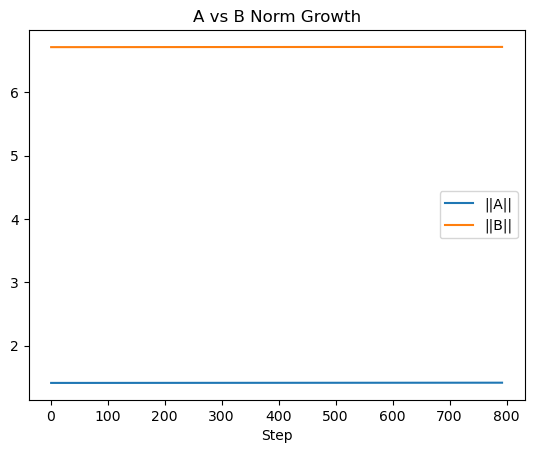

In [3]:
layer = "encoder.layer.0.attention.self.query"
A = df[f"{layer}/norm_A"]
B = df[f"{layer}/norm_B"]

plt.plot(df["step"], A, label="||A||")
plt.plot(df["step"], B, label="||B||")
plt.legend()
plt.xlabel("Step")
plt.title("A vs B Norm Growth")
plt.show()


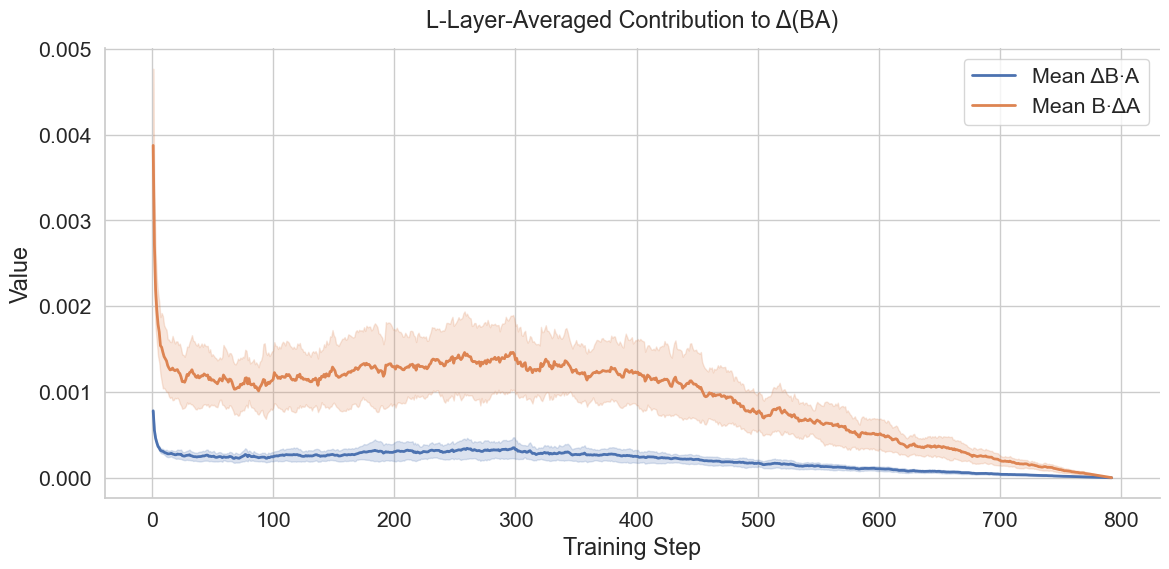

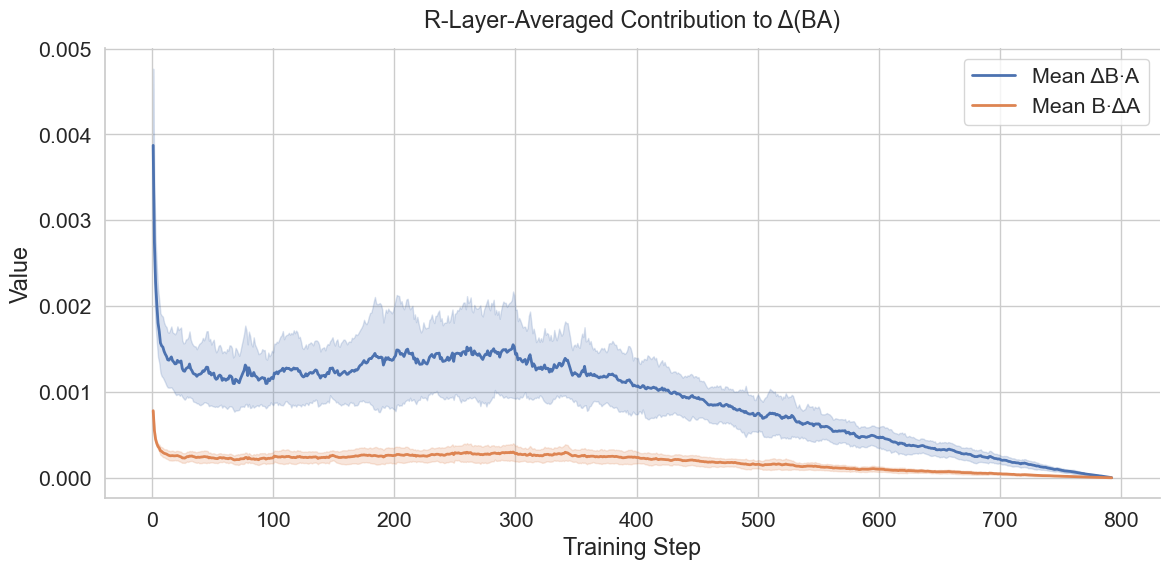

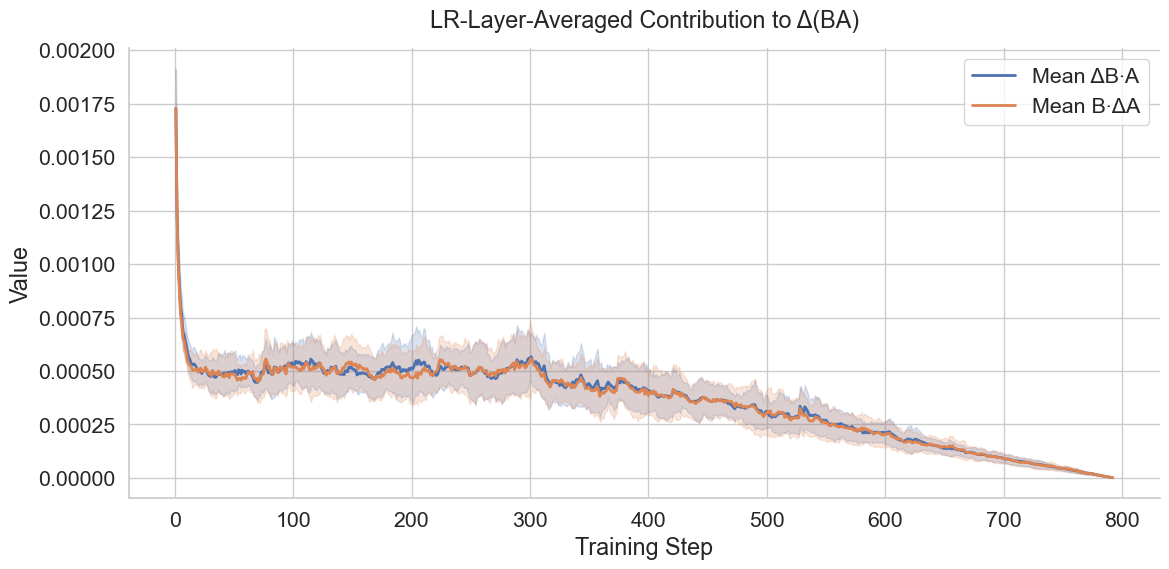

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_mean_with_shading_seaborn(df, num_layers, p=''):
    sns.set_theme(style="whitegrid", font_scale=1.4)
    
    steps = df["step"]

    deltaB_A_all = []
    B_deltaA_all = []

    for i in range(num_layers):
        prefix = f"encoder.layer.{i}.attention.self.query"
        deltaB_A_all.append(df[f"{prefix}/eff_deltaB_A"].values)
        B_deltaA_all.append(df[f"{prefix}/eff_B_deltaA"].values)

    deltaB_A_all = np.vstack(deltaB_A_all)
    B_deltaA_all = np.vstack(B_deltaA_all)

    mean_dBA = deltaB_A_all.mean(axis=0)
    std_dBA  = deltaB_A_all.std(axis=0)

    mean_BdA = B_deltaA_all.mean(axis=0)
    std_BdA  = B_deltaA_all.std(axis=0)

    plt.figure(figsize=(12, 6))
    palette = sns.color_palette("deep")

    plt.plot(steps, mean_dBA, label="Mean ΔB·A", color=palette[0], linewidth=2)
    plt.fill_between(steps, mean_dBA - std_dBA, mean_dBA + std_dBA,
                     color=palette[0], alpha=0.2)
    plt.plot(steps, mean_BdA, label="Mean B·ΔA", color=palette[1], linewidth=2)
    plt.fill_between(steps, mean_BdA - std_BdA, mean_BdA + std_BdA,
                     color=palette[1], alpha=0.2)

    plt.xlabel("Training Step")
    plt.ylabel("Value")
    plt.title(f"{p}-Layer-Averaged Contribution to Δ(BA)", pad=15)
    plt.legend()
    
    sns.despine()
    plt.tight_layout()
    plt.savefig(f"{p}_layer_averaged_contribution.svg", format="svg", bbox_inches="tight")
    
    plt.show()

plot_mean_with_shading_seaborn(df_left, num_layers=12, p='L')
plot_mean_with_shading_seaborn(df_right, num_layers=12, p='R')
plot_mean_with_shading_seaborn(df_leftright, num_layers=12, p='LR')

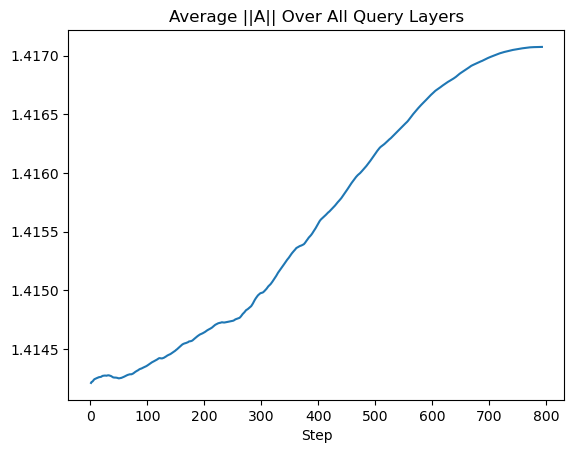

In [5]:
import re

pattern = re.compile(r"encoder\.layer\.(\d+)\.attention\.self\.query/norm_A")

query_A_keys = [c for c in df.columns if pattern.match(c)]

mean_A = df[query_A_keys].mean(axis=1)
plt.plot(df["step"], mean_A)
plt.title("Average ||A|| Over All Query Layers")
plt.xlabel("Step")
plt.show()
